Part 3 - Predictive modeling

Kellin Pelrine

In [0]:
import pandas as pd
# note: whether this will work depends on your pandas version; might need to load data differently.
# I'm running this on google colab. Later, when I install auto_ml, this will break 
with open('ultimate_data_challenge.json', 'r') as f:
  data = pd.read_json('ultimate_data_challenge.json')

In [2]:
data

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [4]:
# We have a few missing values in "phone" and "avg_rating_by_driver," and a lot in "avg_rating_of_driver." 
# Phone is categorical, so we can just leave missing as an extra category.
# Let's make an indicator variable for avg_rating_by_driver missing, then replace the missing values with the average for easy modeling.
# Then we'll look into avg_rating_of_driver in more detail since there's a lot missing there.


data['passenger_rating_missing'] = 0
data.passenger_rating_missing[data.avg_rating_by_driver.isna()] = 1
data.avg_rating_by_driver = data.avg_rating_by_driver.fillna(value=data.avg_rating_by_driver.mean())
data.phone[data.phone.isna()] = 'missing'

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   city                      50000 non-null  object 
 1   trips_in_first_30_days    50000 non-null  int64  
 2   signup_date               50000 non-null  object 
 3   avg_rating_of_driver      41878 non-null  float64
 4   avg_surge                 50000 non-null  float64
 5   last_trip_date            50000 non-null  object 
 6   phone                     50000 non-null  object 
 7   surge_pct                 50000 non-null  float64
 8   ultimate_black_user       50000 non-null  bool   
 9   weekday_pct               50000 non-null  float64
 10  avg_dist                  50000 non-null  float64
 11  avg_rating_by_driver      50000 non-null  float64
 12  passenger_rating_missing  50000 non-null  int64  
dtypes: bool(1), float64(6), int64(2), object(4)
memory usage: 4.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,passenger_rating_missing
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.004020
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.445753,0.063277
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,0.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000


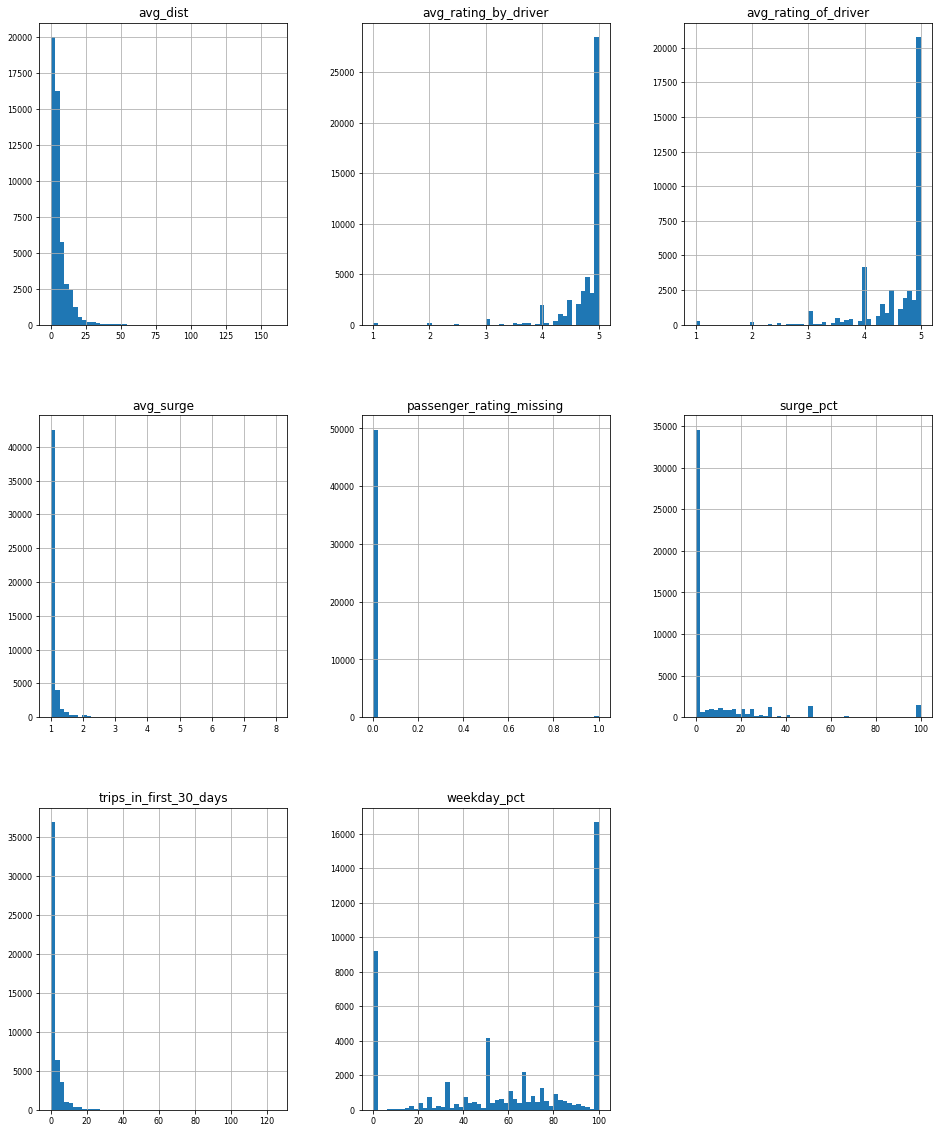

In [5]:
import matplotlib.pyplot as plt

non_bool_cols = list(data.columns)
non_bool_cols.remove('ultimate_black_user')
data[non_bool_cols].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [6]:
# Nothing jumping out above. Now let's look at those entries with missing values.

data_na = data[data.avg_rating_of_driver.isna()]
data_na.info()
data_na.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8122 entries, 6 to 49999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   city                      8122 non-null   object 
 1   trips_in_first_30_days    8122 non-null   int64  
 2   signup_date               8122 non-null   object 
 3   avg_rating_of_driver      0 non-null      float64
 4   avg_surge                 8122 non-null   float64
 5   last_trip_date            8122 non-null   object 
 6   phone                     8122 non-null   object 
 7   surge_pct                 8122 non-null   float64
 8   ultimate_black_user       8122 non-null   bool   
 9   weekday_pct               8122 non-null   float64
 10  avg_dist                  8122 non-null   float64
 11  avg_rating_by_driver      8122 non-null   float64
 12  passenger_rating_missing  8122 non-null   int64  
dtypes: bool(1), float64(6), int64(2), object(4)
memory usage: 832.

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,passenger_rating_missing
count,8122.000000,0.0,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000
mean,0.593327,NaN,1.078210,8.548067,59.050948,7.506267,4.785919,0.008249
std,0.606755,NaN,0.310306,26.578461,46.859739,7.758616,0.619551,0.090455
min,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,NaN,1.000000,0.000000,0.000000,2.410000,5.000000,0.000000
50%,1.000000,NaN,1.000000,0.000000,100.000000,4.715000,5.000000,0.000000
75%,1.000000,NaN,1.000000,0.000000,100.000000,10.720000,5.000000,0.000000
max,5.000000,NaN,5.000000,100.000000,100.000000,160.960000,5.000000,1.000000


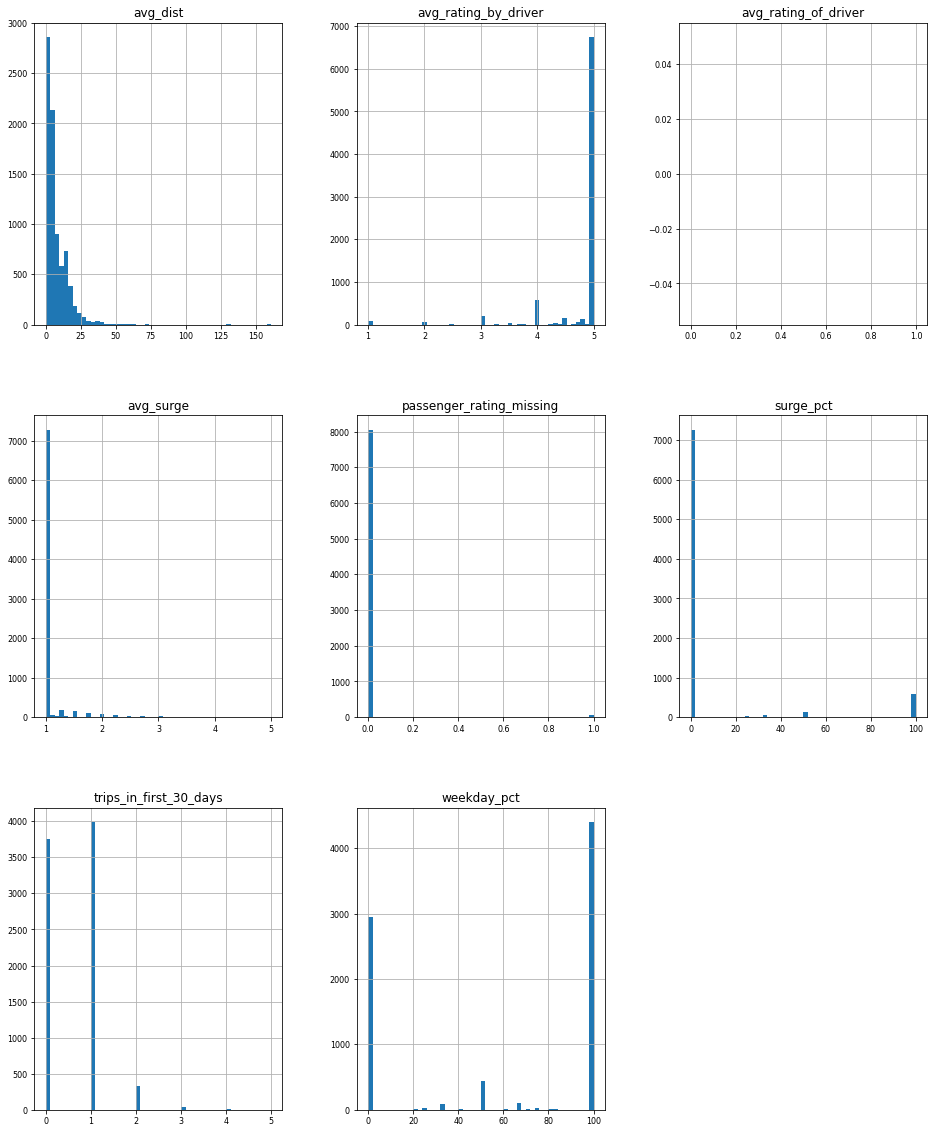

In [7]:
data_na[non_bool_cols].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [8]:
# It looks like they're not taking many trips in the first 30 days, but hard to see if that's significant from here.
# Let's construct the retained variable and then return to this.

data['last_trip_date'].max()

'2014-07-01'

In [9]:
data['retained'] = 0
data.retained[data.last_trip_date > '2014-06-01'] = 1
data.retained = data.retained.astype('int8')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
data_na = data[data.avg_rating_of_driver.isna()]
print(100*data.retained.value_counts() / len(data))
print(100*data_na.retained.value_counts() / len(data_na))

0    63.38
1    36.62
Name: retained, dtype: float64
0    80.69441
1    19.30559
Name: retained, dtype: float64


In [11]:
'''
We see above that about 37% of customers are retained overall.
Among those with avg_rating_of_driver missing it's quite a bit lower, 19%.

I'm guessing this is missing when the user isn't rating the driver, though not completely certain.
Given this appears to have predictive importance, I'm going to give it its own indicator variable, 
and then fill the nan with the mean to facilitate modeling.
'''

data['rating_missing'] = 0
data.rating_missing[data.avg_rating_of_driver.isna()] = 1
data.avg_rating_of_driver = data.avg_rating_of_driver.fillna(value=data.avg_rating_of_driver.mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [12]:
# Since this project needs to be completed in a short amount of time, let's use auto_ml.
# While it may not give us as good results as a model handcrafted with a week of work, 
# it should be much better than a model constructed with poor model selection/tuning/etc.

!pip install auto_ml

     |████████████████████████████████| 71kB 2.4MB/s 
     |████████████████████████████████| 153kB 9.1MB/s 
     |████████████████████████████████| 163kB 18.2MB/s 
     |████████████████████████████████| 634kB 19.4MB/s 
     |████████████████████████████████| 10.4MB 24.4MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 112kB 47.9MB/s 
     |████████████████████████████████| 163kB 44.5MB/s 
  Created wheel for dill: filename=dill-0.2.9-cp36-none-any.whl size=77404 sha256=8919b2b624dee69e01d8884e39de5c8d30b65685b6fd584fafc8af13e5f10971
  Stored in directory: /root/.cache/pip/wheels/5b/d7/0f/e58eae695403de585269f4e4a94e0cd6ca60ec0c202936fa4a
  Created wheel for pathos: filename=pathos-0.2.5-cp36-none-any.whl size=77577 sha256=254c171c6f30c0445adc1324c704e7e78e930eaec270e7cdeabc35648ed0b3df
  Stored in directory: /root/.cache/pip/wheels/61/6d/83/90b0c3d2c271da2c4850731e894798c98f8dbedbac74e8eff0
  Created wheel for sklearn-deap2: filename=

In [0]:
from sklearn.model_selection import train_test_split

input_cols = list(data.columns)
response_col = 'retained'
input_cols.remove(response_col)
data.signup_date = pd.to_datetime(data['signup_date'])
data.last_trip_date = pd.to_datetime(data['last_trip_date'])
X_train, X_test, y_train, y_test = train_test_split(data[input_cols], data[response_col], test_size=0.30, random_state=42)

In [14]:
df_train = X_train.join(y_train)
df_test = X_test.join(y_test)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 38094 to 15795
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   city                      35000 non-null  object        
 1   trips_in_first_30_days    35000 non-null  int64         
 2   signup_date               35000 non-null  datetime64[ns]
 3   avg_rating_of_driver      35000 non-null  float64       
 4   avg_surge                 35000 non-null  float64       
 5   last_trip_date            35000 non-null  datetime64[ns]
 6   phone                     35000 non-null  object        
 7   surge_pct                 35000 non-null  float64       
 8   ultimate_black_user       35000 non-null  bool          
 9   weekday_pct               35000 non-null  float64       
 10  avg_dist                  35000 non-null  float64       
 11  avg_rating_by_driver      35000 non-null  float64       
 12  passenger_rati

In [15]:
from auto_ml import Predictor

column_descriptions = {
    'retained': 'output',
    'city': 'categorical',
    'signup_date': 'date',
    'last_trip_date': 'date',
    'phone': 'categorical',
    'ultimate_black_user': 'categorical',
    'rating_missing': 'categorical'
}

ml_predictor = Predictor(type_of_estimator='classifier', column_descriptions=column_descriptions)

ml_predictor.train(df_train)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'presort': False, 'learning_rate': 0.1, 'warm_start': True}
Running basic data cleaning
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'presort': False, 'learning_rate': 0.1, 'warm_start': True}


********************************************************************************************
About to fit the pipeline for the model GradientBoostingClassifier to predict retained
Started at:

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[2] random_holdout_set_from_training_data's score is: -0.21
[3] random_holdout_set_from_training_data's score is: -0.202
[4] random_holdout_set_from_training_data's score is: -0.196


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[5] random_holdout_set_from_training_data's score is: -0.19
[6] random_holdout_set_from_training_data's score is: -0.186
[7] random_holdout_set_from_training_data's score is: -0.181


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[8] random_holdout_set_from_training_data's score is: -0.178
[9] random_holdout_set_from_training_data's score is: -0.174
[10] random_holdout_set_from_training_data's score is: -0.17


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[11] random_holdout_set_from_training_data's score is: -0.168
[12] random_holdout_set_from_training_data's score is: -0.166
[13] random_holdout_set_from_training_data's score is: -0.164


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[14] random_holdout_set_from_training_data's score is: -0.162
[15] random_holdout_set_from_training_data's score is: -0.16


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[16] random_holdout_set_from_training_data's score is: -0.158
[17] random_holdout_set_from_training_data's score is: -0.157


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[18] random_holdout_set_from_training_data's score is: -0.156
[19] random_holdout_set_from_training_data's score is: -0.154
[20] random_holdout_set_from_training_data's score is: -0.154
[21] random_holdout_set_from_training_data's score is: -0.153


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[22] random_holdout_set_from_training_data's score is: -0.152
[23] random_holdout_set_from_training_data's score is: -0.151


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[24] random_holdout_set_from_training_data's score is: -0.15
[25] random_holdout_set_from_training_data's score is: -0.15


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[26] random_holdout_set_from_training_data's score is: -0.149
[27] random_holdout_set_from_training_data's score is: -0.149


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[28] random_holdout_set_from_training_data's score is: -0.148
[29] random_holdout_set_from_training_data's score is: -0.148


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[30] random_holdout_set_from_training_data's score is: -0.147
[31] random_holdout_set_from_training_data's score is: -0.147


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[32] random_holdout_set_from_training_data's score is: -0.146
[33] random_holdout_set_from_training_data's score is: -0.146


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[34] random_holdout_set_from_training_data's score is: -0.146
[35] random_holdout_set_from_training_data's score is: -0.145


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[36] random_holdout_set_from_training_data's score is: -0.145
[37] random_holdout_set_from_training_data's score is: -0.145


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[38] random_holdout_set_from_training_data's score is: -0.144
[39] random_holdout_set_from_training_data's score is: -0.144


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[40] random_holdout_set_from_training_data's score is: -0.144
[41] random_holdout_set_from_training_data's score is: -0.144


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[42] random_holdout_set_from_training_data's score is: -0.143
[43] random_holdout_set_from_training_data's score is: -0.143


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[44] random_holdout_set_from_training_data's score is: -0.143
[45] random_holdout_set_from_training_data's score is: -0.143


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[46] random_holdout_set_from_training_data's score is: -0.143
[47] random_holdout_set_from_training_data's score is: -0.142


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[48] random_holdout_set_from_training_data's score is: -0.142
[49] random_holdout_set_from_training_data's score is: -0.142


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[50] random_holdout_set_from_training_data's score is: -0.142
[52] random_holdout_set_from_training_data's score is: -0.142


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[54] random_holdout_set_from_training_data's score is: -0.141
[56] random_holdout_set_from_training_data's score is: -0.141


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[58] random_holdout_set_from_training_data's score is: -0.141


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[60] random_holdout_set_from_training_data's score is: -0.141


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[62] random_holdout_set_from_training_data's score is: -0.141


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[64] random_holdout_set_from_training_data's score is: -0.141


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[66] random_holdout_set_from_training_data's score is: -0.14


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[68] random_holdout_set_from_training_data's score is: -0.14


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[70] random_holdout_set_from_training_data's score is: -0.14


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[72] random_holdout_set_from_training_data's score is: -0.14


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[74] random_holdout_set_from_training_data's score is: -0.14


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[76] random_holdout_set_from_training_data's score is: -0.14


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[78] random_holdout_set_from_training_data's score is: -0.14


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[80] random_holdout_set_from_training_data's score is: -0.14


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[82] random_holdout_set_from_training_data's score is: -0.14


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[84] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[86] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[88] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[90] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[92] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[94] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[96] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[98] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[100] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[103] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[106] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[109] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[112] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[115] random_holdout_set_from_training_data's score is: -0.139


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[118] random_holdout_set_from_training_data's score is: -0.138


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[121] random_holdout_set_from_training_data's score is: -0.138


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[124] random_holdout_set_from_training_data's score is: -0.138


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[127] random_holdout_set_from_training_data's score is: -0.138


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[130] random_holdout_set_from_training_data's score is: -0.138


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[133] random_holdout_set_from_training_data's score is: -0.138


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[136] random_holdout_set_from_training_data's score is: -0.138


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[139] random_holdout_set_from_training_data's score is: -0.138


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[142] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[145] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[148] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[151] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[154] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[157] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[160] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[163] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[166] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[169] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[172] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[175] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[178] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[181] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[184] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[187] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[190] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[193] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[196] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[199] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[202] random_holdout_set_from_training_data's score is: -0.137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[205] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[208] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[211] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[214] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[217] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[220] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[223] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[226] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[229] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[232] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[235] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[238] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[241] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[244] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[247] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[250] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[255] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[260] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[265] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[270] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[275] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[280] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[285] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[290] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[295] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[300] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[305] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[310] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[315] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[320] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[325] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[330] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[335] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[340] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[345] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[350] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[355] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[360] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[365] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[370] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[375] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[380] random_holdout_set_from_training_data's score is: -0.136


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[385] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[390] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[395] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[400] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[405] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[410] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[415] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[420] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[425] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[430] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[435] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[440] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[445] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[450] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[455] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[460] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[465] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[470] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[475] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[480] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[485] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[490] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[495] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[500] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[510] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[520] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[530] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[540] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[550] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[560] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[570] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[580] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[590] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[600] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[610] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[620] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[630] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[640] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[650] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[660] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[670] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[680] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[690] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[700] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[710] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[720] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[730] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[740] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[750] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[760] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[770] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[780] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[790] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[800] random_holdout_set_from_training_data's score is: -0.135


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[810] random_holdout_set_from_training_data's score is: -0.135
The number of estimators that were the best for this training dataset: 610
The best score on the holdout set: -0.1350436359793623
Finished training the pipeline!
Total training time:
0:01:52


Here are the results from our GradientBoostingClassifier
predicting retained
Calculating feature responses, for advanced analytics.
The printed list will only contain at most the top 100 features.
+----+------------------------------------+--------------+----------+-------------------+-------------------+-----------+-----------+-----------+-----------+
|    | Feature Name                       |   Importance |    Delta |   FR_Decrementing |   FR_Incrementing |   FRD_abs |   FRI_abs |   FRD_MAD |   FRI_MAD |
|----+------------------------------------+--------------+----------+-------------------+-------------------+-----------+-----------+-----------+-----------|
| 13 | last_trip_date_hour                |       0.0000 |   0.0000 |    

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [17]:
ml_predictor.score(df_test, df_test.retained)

Here is our brier-score-loss, which is the default value we optimized for while training, and is the value returned from .score() unless you requested a custom scoring metric
It is a measure of how close the PROBABILITY predictions are.
0.1442

Here is the trained estimator's overall accuracy (when it predicts a label, how frequently is that the correct label?)
79.4%

Here is a confusion matrix showing predictions vs. actuals by label:
Predicted >      0     1    All
v Actual v                     
0             8237  1286   9523
1             1801  3676   5477
All          10038  4962  15000

Here is predictive value by class:
Class:  1 = 0.7408303103587264
Class:  0 = 0.8205817892010361
+---------------------------------+-----------------------------------+--------------------------------+
| Bucket Edges                    |   Predicted Probability Of Bucket |   Actual Probability of Bucket |
|---------------------------------+-----------------------------------+---------------------

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:3848: FutureWarning: 'is_extension_type' is deprecated and will be removed in a future version.  Use 'is_extension_array_dtype' instead.
  --------


-0.1441646589116904

From the feature importances above, we can see that avg_rating_by_driver, surge_pct, and weekday_pct, and King's Landing are important predictors. 

I'm not sure exactly what surge_pct represents, but if it's some marketing or promotional thing, this might suggest we can improve retention through that or similar programs. Also, this analysis indicates differences between cities are important, which could warrant further investigation and potentially targeted marketing or other interventions.